# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:

import tensorflow as tf

### set gpu backend
def setGPU(backend, GPU):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.visible_device_list = GPU
    #session = tf.Session(config=config)
    backend.tensorflow_backend.set_session(tf.Session(config=config))


    
    # select GPU, usually only one
from keras import backend as K

setGPU(K, "1")
import keras

# from keras import backend as K
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True


Using TensorFlow backend.


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [3]:
COCO_MODEL_PATH

'/media/nexus/storage4/github/Mask_RCNN/mask_rcnn_coco.h5'

## Configurations

In [4]:
from mrcnn.config import Config

class MouseConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mouse"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.95
    
    
    GPU_COUNT = 1

class MouseDataset(utils.Dataset):

    def load_mouse(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("mouse", 1, "mouse")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "mouse",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
#         if image_info["source"] != "mouse":
#             return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mouse":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
            

In [5]:
config = MouseConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
import json
import skimage

In [8]:
config = MouseConfig()
MOUSE_DIR = os.path.join(ROOT_DIR, "samples/my_mouse")

In [9]:
# Training dataset
dataset_train = MouseDataset()
dataset_train.load_mouse(MOUSE_DIR, "train")
dataset_train.prepare()

# # Validation dataset
dataset_val = MouseDataset()
dataset_val.load_mouse(MOUSE_DIR, "val")
dataset_val.prepare()

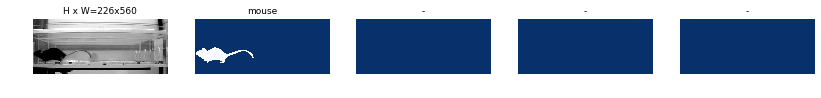

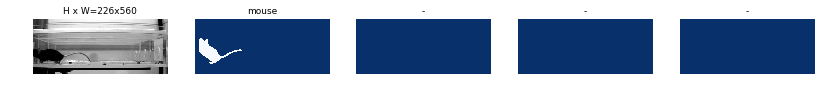

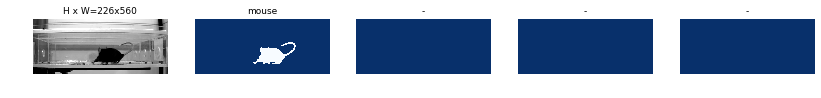

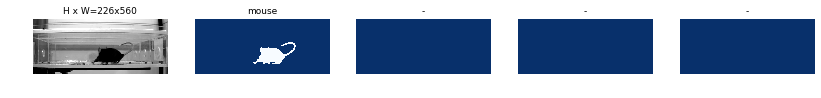

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads',
#            validation_split = 0.2,
           )

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /media/nexus/storage4/github/Mask_RCNN/logs/mouse20190529T0155/mask_rcnn_mouse_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Co

/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/nexus/anaconda2/envs/pbt-keras36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
100/100 [==============================] - 467s 5s/step - loss: 1.8152 - rpn_class_loss: 0.2765 - rpn_bbox_loss: 0.3907 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.5456 - mrcnn_mask_loss: 0.5446 - val_loss: 1.5524 - val_rpn_class_loss: 0.0409 - val_rpn_bbox_loss: 0.2108 - val_mrcnn_class_loss: 0.0275 - val_mrcnn_bbox_loss: 0.5917 - val_mrcnn_mask_loss: 0.6816


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(MouseConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [91]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  645.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


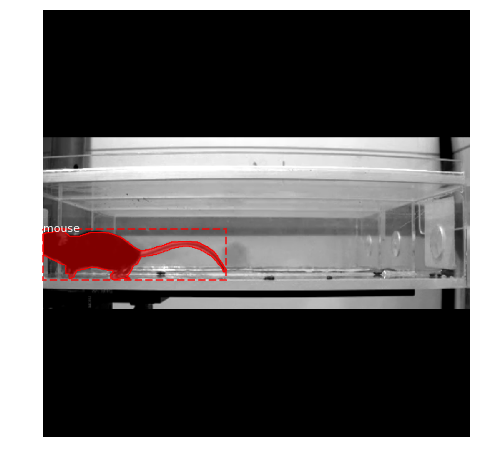

In [92]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


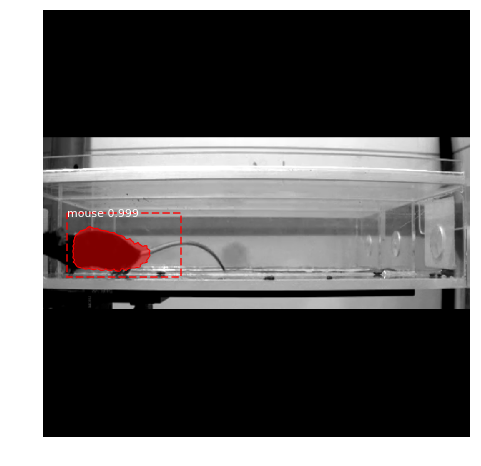

In [93]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [94]:
for res in results:
    print(res['scores'])

[0.99864906]


## Evaluation

In [193]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


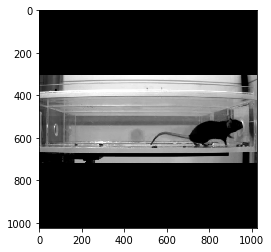

In [194]:
plt.imshow(image)

In [195]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   16.72758  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   18.75992  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   31.41985  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -18.47508  max:   20.39524  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


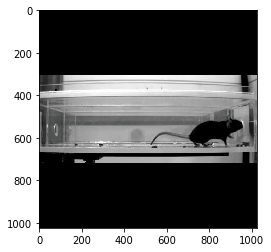

In [196]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [197]:
from mrcnn import visualize
from mrcnn.visualize import display_images

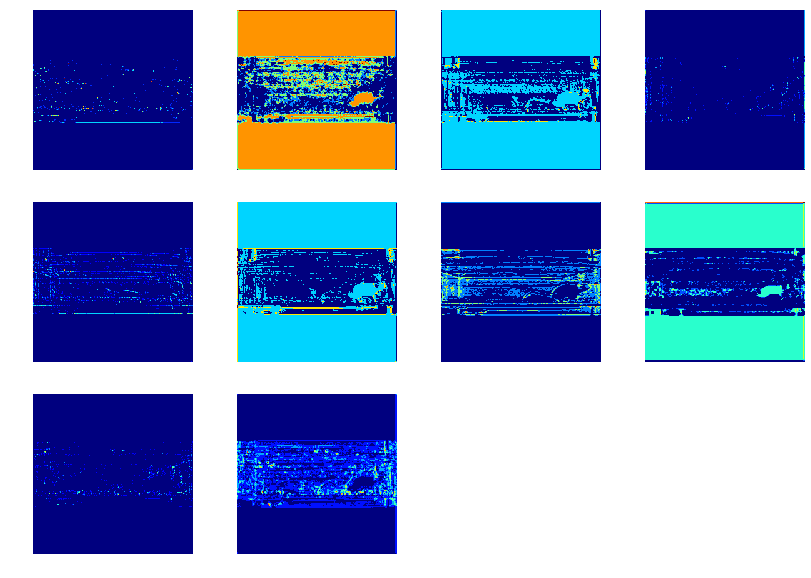

In [198]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:10], [2, 0, 1]), cols=4, cmap='jet')

In [336]:
original_image = img

# extract bounding boxes

Processing 1 images
image                    shape: (115, 550, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


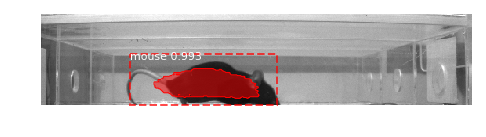

In [337]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [338]:
get_img = original_image[r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]

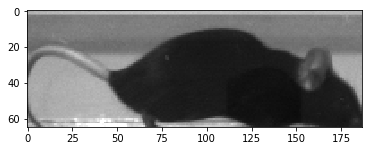

In [339]:
plt.imshow(get_img)

In [340]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (115, 550, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


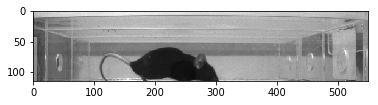

In [341]:
plt.imshow(original_image)

In [342]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

In [343]:
original_image.shape

(1024, 1024, 3)

In [481]:
# test = '/media/nexus/storage3/BEHAVIORDECODING_main/2019-05-28_Mouse_ID_3mice_00naivebehavior/data_manta/'

test = '/media/nexus/storage3/BEHAVIORDECODING_main/2019-05-27_Mouse_ID_3_00naivebehavior/data_manta/'


In [482]:
from glob import glob

In [483]:
files = glob(test + "*.npy")

In [484]:
# func
def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [485]:
files.sort(key=natural_keys)

In [486]:
import numpy as np

In [487]:
import os.path
import numpy as np
from PIL import Image



def numpy2pil(np_array: np.ndarray) -> Image:
    """
    Convert an HxWx3 numpy array into an RGB Image
    """

    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img


In [488]:

a = np.load(files[3333])[140:255,75:625]
img = [a]*3

img = np.asarray(img)

img = np.swapaxes(img, 0, 1)
img = np.swapaxes(img, 1, 2)

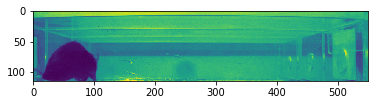

In [489]:
plt.imshow(img[:,:,2])

In [490]:
from tqdm import tqdm

In [491]:
length = 200

In [492]:
imgs = np.zeros((length, 125,300,3))

In [493]:
imgs.shape

(200, 125, 300, 3)

In [494]:



# imgs = []

for i in tqdm(range(0,length)):
    

    a = np.load(files[i])[140:255,75:625]
    img = [a]*3

    img = np.asarray(img)

    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    
    results = model.detect([img], verbose=1)
    try:
        print('yo')
        r = results[0]
        r['rois'][0]
        
        y1 = r['rois'][0][2] - r['rois'][0][0]
        y2 = r['rois'][0][3] - r['rois'][0][1]
        
        imgs[i,:y1,:y2,:] = img[r['rois'][0][0]:r['rois'][0][2],r['rois'][0][1]:r['rois'][0][3]]
    except IndexError:
        continue

    

  0%|          | 0/200 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  0%|          | 1/200 [00:00<02:45,  1.20it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  1%|          | 2/200 [00:01<02:41,  1.23it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  2%|▏         | 3/200 [00:02<02:38,  1.24it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  2%|▏         | 4/200 [00:03<02:36,  1.25it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  2%|▎         | 5/200 [00:03<02:34,  1.26it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  3%|▎         | 6/200 [00:04<02:35,  1.25it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  4%|▎         | 7/200 [00:05<02:33,  1.25it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  4%|▍         | 8/200 [00:06<02:31,  1.27it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  4%|▍         | 9/200 [00:07<02:28,  1.28it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  5%|▌         | 10/200 [00:07<02:25,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  6%|▌         | 11/200 [00:08<02:26,  1.29it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  6%|▌         | 12/200 [00:09<02:25,  1.29it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  6%|▋         | 13/200 [00:10<02:25,  1.29it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  7%|▋         | 14/200 [00:10<02:22,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  8%|▊         | 15/200 [00:11<02:22,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  8%|▊         | 16/200 [00:12<02:20,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  8%|▊         | 17/200 [00:13<02:20,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


  9%|▉         | 18/200 [00:13<02:19,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 10%|▉         | 19/200 [00:14<02:18,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 10%|█         | 20/200 [00:15<02:17,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 10%|█         | 21/200 [00:16<02:17,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 11%|█         | 22/200 [00:17<02:16,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 12%|█▏        | 23/200 [00:17<02:14,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 12%|█▏        | 24/200 [00:18<02:14,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 12%|█▎        | 25/200 [00:19<02:12,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 13%|█▎        | 26/200 [00:20<02:11,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 14%|█▎        | 27/200 [00:20<02:09,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 14%|█▍        | 28/200 [00:21<02:09,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 14%|█▍        | 29/200 [00:22<02:07,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 15%|█▌        | 30/200 [00:23<02:09,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 16%|█▌        | 31/200 [00:23<02:08,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 16%|█▌        | 32/200 [00:24<02:08,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 16%|█▋        | 33/200 [00:25<02:08,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 17%|█▋        | 34/200 [00:26<02:07,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 18%|█▊        | 35/200 [00:26<02:05,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 18%|█▊        | 36/200 [00:27<02:04,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 18%|█▊        | 37/200 [00:28<02:03,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 19%|█▉        | 38/200 [00:29<02:02,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 20%|█▉        | 39/200 [00:29<02:01,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 20%|██        | 40/200 [00:30<02:02,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 20%|██        | 41/200 [00:31<02:00,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 21%|██        | 42/200 [00:32<02:00,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 22%|██▏       | 43/200 [00:32<01:57,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 22%|██▏       | 44/200 [00:33<01:58,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 22%|██▎       | 45/200 [00:34<01:57,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 23%|██▎       | 46/200 [00:35<01:56,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 24%|██▎       | 47/200 [00:35<01:55,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 24%|██▍       | 48/200 [00:36<01:54,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 24%|██▍       | 49/200 [00:37<01:54,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 25%|██▌       | 50/200 [00:38<01:53,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 26%|██▌       | 51/200 [00:39<01:52,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 26%|██▌       | 52/200 [00:39<01:52,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 26%|██▋       | 53/200 [00:40<01:51,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 27%|██▋       | 54/200 [00:41<01:50,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 28%|██▊       | 55/200 [00:42<01:51,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 28%|██▊       | 56/200 [00:42<01:49,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 28%|██▊       | 57/200 [00:43<01:48,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 29%|██▉       | 58/200 [00:44<01:45,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 30%|██▉       | 59/200 [00:44<01:43,  1.37it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 30%|███       | 60/200 [00:45<01:42,  1.36it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 30%|███       | 61/200 [00:46<01:42,  1.36it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 31%|███       | 62/200 [00:47<01:42,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 32%|███▏      | 63/200 [00:47<01:42,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 32%|███▏      | 64/200 [00:48<01:41,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 32%|███▎      | 65/200 [00:49<01:40,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 33%|███▎      | 66/200 [00:50<01:40,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 34%|███▎      | 67/200 [00:50<01:39,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 34%|███▍      | 68/200 [00:51<01:38,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 34%|███▍      | 69/200 [00:52<01:37,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 35%|███▌      | 70/200 [00:53<01:37,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 36%|███▌      | 71/200 [00:53<01:36,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 36%|███▌      | 72/200 [00:54<01:35,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 36%|███▋      | 73/200 [00:55<01:35,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 37%|███▋      | 74/200 [00:56<01:35,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 38%|███▊      | 75/200 [00:57<01:34,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 38%|███▊      | 76/200 [00:57<01:33,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 38%|███▊      | 77/200 [00:58<01:33,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 39%|███▉      | 78/200 [00:59<01:32,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 40%|███▉      | 79/200 [01:00<01:31,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 40%|████      | 80/200 [01:00<01:30,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 40%|████      | 81/200 [01:01<01:29,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 41%|████      | 82/200 [01:02<01:29,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 42%|████▏     | 83/200 [01:03<01:28,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 42%|████▏     | 84/200 [01:03<01:27,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 42%|████▎     | 85/200 [01:04<01:26,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 43%|████▎     | 86/200 [01:05<01:26,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 44%|████▎     | 87/200 [01:06<01:25,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 44%|████▍     | 88/200 [01:06<01:25,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 44%|████▍     | 89/200 [01:07<01:25,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 45%|████▌     | 90/200 [01:08<01:23,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 46%|████▌     | 91/200 [01:09<01:23,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 46%|████▌     | 92/200 [01:09<01:22,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 46%|████▋     | 93/200 [01:10<01:21,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 47%|████▋     | 94/200 [01:11<01:20,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 48%|████▊     | 95/200 [01:12<01:18,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 48%|████▊     | 96/200 [01:12<01:17,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 48%|████▊     | 97/200 [01:13<01:16,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 49%|████▉     | 98/200 [01:14<01:16,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 50%|████▉     | 99/200 [01:15<01:15,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 50%|█████     | 100/200 [01:15<01:15,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 50%|█████     | 101/200 [01:16<01:14,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 51%|█████     | 102/200 [01:17<01:15,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 52%|█████▏    | 103/200 [01:18<01:14,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 52%|█████▏    | 104/200 [01:18<01:13,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 52%|█████▎    | 105/200 [01:19<01:12,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 53%|█████▎    | 106/200 [01:20<01:11,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 54%|█████▎    | 107/200 [01:21<01:10,  1.31it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 54%|█████▍    | 108/200 [01:21<01:09,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 55%|█████▍    | 109/200 [01:22<01:08,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 55%|█████▌    | 110/200 [01:23<01:07,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 56%|█████▌    | 111/200 [01:24<01:06,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 56%|█████▌    | 112/200 [01:24<01:06,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 56%|█████▋    | 113/200 [01:25<01:05,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 57%|█████▋    | 114/200 [01:26<01:04,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 57%|█████▊    | 115/200 [01:27<01:03,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 58%|█████▊    | 116/200 [01:27<01:02,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 58%|█████▊    | 117/200 [01:28<01:01,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 59%|█████▉    | 118/200 [01:29<01:01,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 60%|█████▉    | 119/200 [01:30<01:01,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 60%|██████    | 120/200 [01:30<01:00,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 60%|██████    | 121/200 [01:31<00:59,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 61%|██████    | 122/200 [01:32<00:59,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 62%|██████▏   | 123/200 [01:33<00:58,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 62%|██████▏   | 124/200 [01:34<00:57,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 62%|██████▎   | 125/200 [01:34<00:56,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 63%|██████▎   | 126/200 [01:35<00:55,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 64%|██████▎   | 127/200 [01:36<00:54,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 64%|██████▍   | 128/200 [01:36<00:54,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 64%|██████▍   | 129/200 [01:37<00:53,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 65%|██████▌   | 130/200 [01:38<00:52,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 66%|██████▌   | 131/200 [01:39<00:52,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 66%|██████▌   | 132/200 [01:39<00:51,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 66%|██████▋   | 133/200 [01:40<00:50,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 67%|██████▋   | 134/200 [01:41<00:49,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 68%|██████▊   | 135/200 [01:42<00:49,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 68%|██████▊   | 136/200 [01:43<00:48,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 68%|██████▊   | 137/200 [01:43<00:47,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 69%|██████▉   | 138/200 [01:44<00:46,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 70%|██████▉   | 139/200 [01:45<00:45,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 70%|███████   | 140/200 [01:46<00:45,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 70%|███████   | 141/200 [01:46<00:44,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 71%|███████   | 142/200 [01:47<00:43,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 72%|███████▏  | 143/200 [01:48<00:42,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 72%|███████▏  | 144/200 [01:49<00:42,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 72%|███████▎  | 145/200 [01:49<00:41,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 73%|███████▎  | 146/200 [01:50<00:40,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 74%|███████▎  | 147/200 [01:51<00:39,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 74%|███████▍  | 148/200 [01:51<00:38,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 74%|███████▍  | 149/200 [01:52<00:38,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 75%|███████▌  | 150/200 [01:53<00:37,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 76%|███████▌  | 151/200 [01:54<00:36,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 76%|███████▌  | 152/200 [01:54<00:35,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 76%|███████▋  | 153/200 [01:55<00:35,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 77%|███████▋  | 154/200 [01:56<00:34,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 78%|███████▊  | 155/200 [01:57<00:33,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 78%|███████▊  | 156/200 [01:57<00:33,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 78%|███████▊  | 157/200 [01:58<00:32,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 79%|███████▉  | 158/200 [01:59<00:31,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 80%|███████▉  | 159/200 [02:00<00:30,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 80%|████████  | 160/200 [02:00<00:29,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 80%|████████  | 161/200 [02:01<00:29,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 81%|████████  | 162/200 [02:02<00:28,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 82%|████████▏ | 163/200 [02:03<00:27,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 82%|████████▏ | 164/200 [02:03<00:26,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 82%|████████▎ | 165/200 [02:04<00:25,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 83%|████████▎ | 166/200 [02:05<00:25,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 84%|████████▎ | 167/200 [02:06<00:24,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 84%|████████▍ | 168/200 [02:06<00:23,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 84%|████████▍ | 169/200 [02:07<00:23,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 85%|████████▌ | 170/200 [02:08<00:22,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 86%|████████▌ | 171/200 [02:09<00:21,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 86%|████████▌ | 172/200 [02:09<00:20,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 86%|████████▋ | 173/200 [02:10<00:20,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 87%|████████▋ | 174/200 [02:11<00:19,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 88%|████████▊ | 175/200 [02:12<00:18,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 88%|████████▊ | 176/200 [02:12<00:18,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 88%|████████▊ | 177/200 [02:13<00:17,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 89%|████████▉ | 178/200 [02:14<00:16,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 90%|████████▉ | 179/200 [02:15<00:15,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 90%|█████████ | 180/200 [02:15<00:14,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 90%|█████████ | 181/200 [02:16<00:14,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 91%|█████████ | 182/200 [02:17<00:13,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 92%|█████████▏| 183/200 [02:18<00:12,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 92%|█████████▏| 184/200 [02:18<00:11,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 92%|█████████▎| 185/200 [02:19<00:11,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 93%|█████████▎| 186/200 [02:20<00:10,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 94%|█████████▎| 187/200 [02:21<00:09,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 94%|█████████▍| 188/200 [02:21<00:08,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 94%|█████████▍| 189/200 [02:22<00:08,  1.37it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 95%|█████████▌| 190/200 [02:23<00:07,  1.36it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 96%|█████████▌| 191/200 [02:24<00:06,  1.36it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 96%|█████████▌| 192/200 [02:24<00:05,  1.36it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 96%|█████████▋| 193/200 [02:25<00:05,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 97%|█████████▋| 194/200 [02:26<00:04,  1.35it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 98%|█████████▊| 195/200 [02:27<00:03,  1.34it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 98%|█████████▊| 196/200 [02:27<00:03,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 98%|█████████▊| 197/200 [02:28<00:02,  1.33it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


 99%|█████████▉| 198/200 [02:29<00:01,  1.30it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


100%|█████████▉| 199/200 [02:30<00:00,  1.32it/s]

yo
Processing 1 images
image                    shape: (115, 550, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


100%|██████████| 200/200 [02:30<00:00,  1.32it/s]

yo


In [495]:
imgs = np.asarray(imgs).astype('uint8')

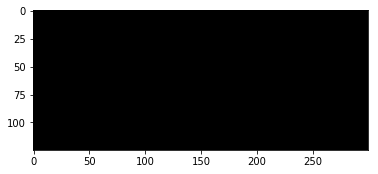

In [496]:
plt.imshow(imgs[88])

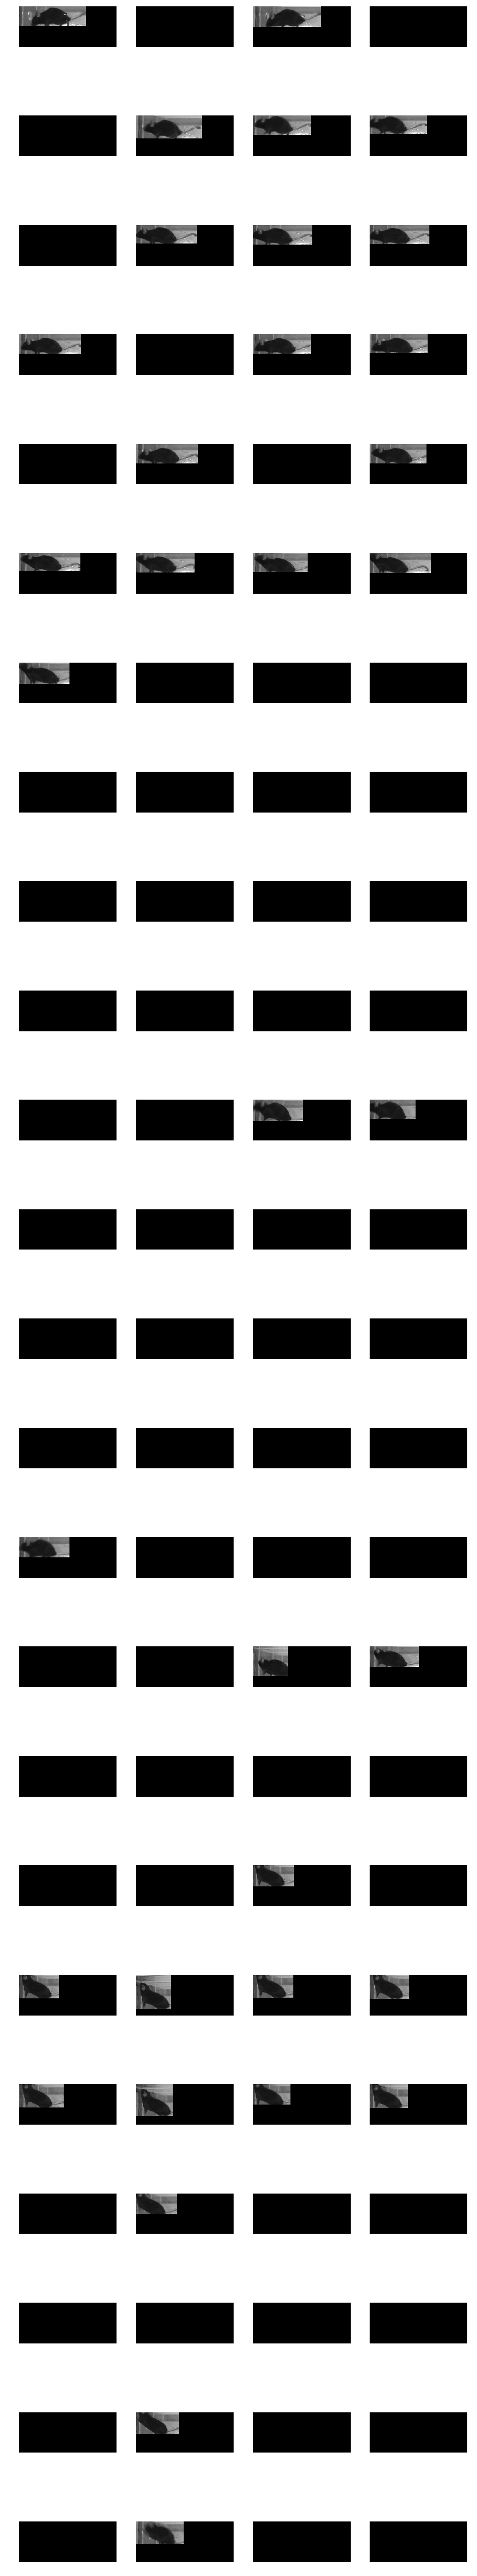

In [497]:
display_images(imgs[:96], cols=4, cmap='jet')

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open(path_animal_1, 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

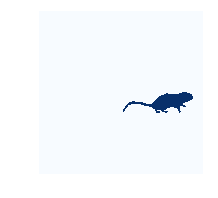

In [458]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")